In this example we will perform an analysis for the app focusing on investigation why people remove app. Our negative target even in this case will be "app_remove".

In [1]:
from retentioneering import init_config
import pandas as pd


init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='not_remove', # name of positive target event
    pos_target_definition={},
    negative_target_event='app_remove', # name of positive target event
)

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('data/mobile-app-data.zip')
data = data.sort_values('event_timestamp')
# problems with timestamp order
data.event_timestamp *= 1000
# adds positive event
data = data.retention.prepare()

Firstly, we need to filter and aggregate events.

To remove specific event simply click on the blue checkbox for selected event. To aggregare group of events to single parent event click on the smaller gray checkbox near parent event.

Now let's remove system events, screen_view, os events, user_engagement, from app we need just app_remove, 

In [3]:
data.retention.show_tree_selector()

After that you need to download created filter with using "Download Filter" link.

Now you can use this filter using next chunk.

Below you can upload filter file we created for the cases we illustrate later in this notebook

In [4]:
data = data.retention.use_tree_filter('filter_list.json')

Lets split data into sessions

In [5]:
data.retention.split_sessions(by_event='session_start')
data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)

# Analysis

## Step matrix

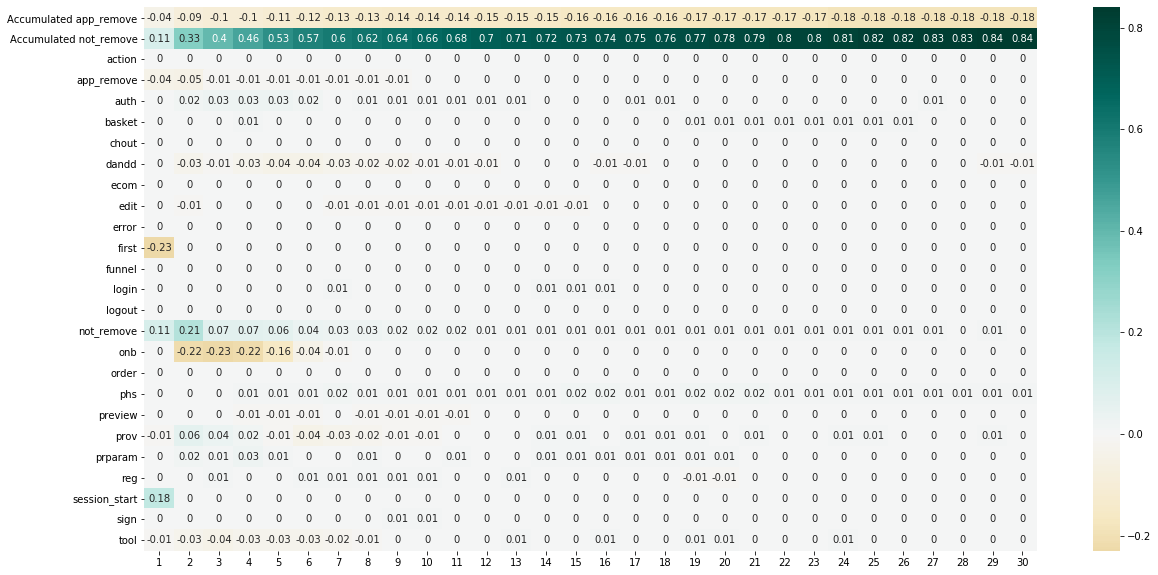

In [6]:
f = data.retention.create_filter(index_col='user_session')
data.retention.get_step_matrix_difference(f, index_col='user_session');

From previous plot we can see that in sessions with removed app, users significantly slows down on onboarding (onb group) and on catalogue (prov group).

This is our first hypothesis about app problems.

## Clustering

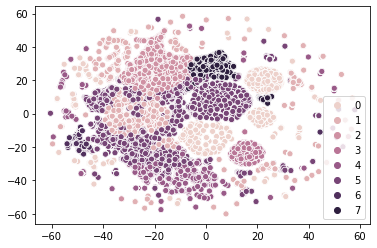

In [7]:
data.retention.learn_tsne(index_col='user_session', plot_type='clusters');

We can choose cluster from center and visualize it

We can see problems with catalogue for zero cluster: a lot of users move from app after first prov event.

In [8]:
data.retention.get_clusters(index_col='user_session');

In [9]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', thresh=0.05))

/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


Selection process involves multiple steps were users edit their selected products and select different kind of options (node "param"). Users can do this without authorization. But after they add selected and customized products to cart they are asked to authorize.

In this cluster we can clearly see the problem with autorization: after authorization we need to return to catalogue (node "prov") and start selection and customization process all over again (node "prparam").

We can see from graph that there is no way to return after authorization to previous step in catalogue (no edge from "auth" to "prparam").

This is a problem in app: authorization brokes user trajectory, so user should return in the beginning.

We can see problems with detailed events via `dump_event_col` column.

In [10]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', cols=['dump_event_col', 'dump_event_col_shift'], thresh=0.08, width=800, height=800))

This graph can support our hypothesis about bad catalogue organization with `prov_click_category_other` event. We can see that users often remove app after this event, wich redirects users to web-page. It's clear example of not optimal app organization where web-page link cannibiling users from mobile app.